<a href="https://colab.research.google.com/github/ziatdinovmax/CSSAS-DML/blob/master/3_cssas_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model training

Prepared by Maxim Ziatdinov (October 2019)


---
This notebook loads training data data and performs a training of a fully convolutional neural network for finding "particles" in noisy microscopy data. It has an option of starting the training with the weights of the already trained model, which may save some time.


---




In [0]:
#@title Import modules
# Data manipulation and plotting
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
#@title Load custom modules { form-width: "20%" }

def load_torchmodel(weights_path, model):
    '''Loads saved weights into a model'''
    if torch.cuda.device_count() > 0:
        checkpoint = torch.load(weights_path)
    else:
        checkpoint = torch.load(weights_path, map_location='cpu')
    model.load_state_dict(checkpoint)
    return model
    
class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output

class dilation_block(nn.Module):
    '''
    Creates a block with dilated convolutional
    layers (aka atrous convolutions)
    '''
    def __init__(self, input_channels, output_channels,
                 dilation_values, padding_values,
                 kernel_size=3, stride=1, lrelu_a=0.01,
                 use_batchnorm=False, dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            dilation_values: list of dilation rates for convolution operation
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
            '''
        super(dilation_block, self).__init__()
        atrous_module = []
        for idx, (dil, pad) in enumerate(zip(dilation_values, padding_values)):
            input_channels = output_channels if idx > 0 else input_channels
            atrous_module.append(nn.Conv2d(input_channels,
                                           output_channels,
                                           kernel_size=kernel_size,
                                           stride=stride,
                                           padding=pad,
                                           dilation=dil,
                                           bias=True))
            if dropout_ > 0:
                atrous_module.append(nn.Dropout(dropout_))
            atrous_module.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                atrous_module.append(nn.BatchNorm2d(output_channels))
        self.atrous_module = nn.Sequential(*atrous_module)

    def forward(self, x):
        '''Forward path'''
        atrous_layers = []
        for conv_layer in self.atrous_module:
            x = conv_layer(x)
            atrous_layers.append(x.unsqueeze(-1))
        return torch.sum(torch.cat(atrous_layers, dim=-1), dim=-1)

class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)



class atomsegnet(nn.Module):
    '''
    Builds  a fully convolutional neural network model
    '''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_filters: number of filters in the first convolutional layer
        '''
        super(atomsegnet, self).__init__()
        self.pxac = 'sigmoid' if nb_classes < 2 else 'softmax'
        self.c1 = conv2dblock(1, nb_filters)
        
        self.c2 = nn.Sequential(conv2dblock(nb_filters,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.c3 = nn.Sequential(conv2dblock(nb_filters*2,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.bn = dilation_block(nb_filters*4,
                                 nb_filters*8,
                                 dilation_values=[2, 4, 6],
                                 padding_values=[2, 4, 6],
                                 dropout_=0.5)
        
        self.upsample_block1 = upsample_block(nb_filters*8,
                                              nb_filters*4)
        
        self.c4 = nn.Sequential(conv2dblock(nb_filters*8,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.upsample_block2 = upsample_block(nb_filters*4,
                                              nb_filters*2)
        
        self.c5 = nn.Sequential(conv2dblock(nb_filters*4,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.upsample_block3 = upsample_block(nb_filters*2,
                                              nb_filters)
        
        self.c6 = conv2dblock(nb_filters*2,
                              nb_filters)
        
        self.px = nn.Conv2d(nb_filters,
                            nb_classes,
                            kernel_size=1,
                            stride=1,
                            padding=0)
               
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.c3(d2)
        d3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        # Atrous convolutions
        bn = self.bn(d3)
        # Expanding path
        u3 = self.upsample_block1(bn)
        u3 = torch.cat([c3, u3], dim=1)
        u3 = self.c4(u3)
        u2 = self.upsample_block2(u3)
        u2 = torch.cat([c2, u2], dim=1)
        u2 = self.c5(u2)
        u1 = self.upsample_block3(u2)
        u1 = torch.cat([c1, u1], dim=1)
        u1 = self.c6(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output

## Load training data

Mount google drive:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load training data:

In [0]:
# specify directory with data in google drive
datadir = 'drive/Shared drives/CSSAS-ML/training_data'

images_all = np.load(
    os.path.join(datadir, 'pnnl_training_images.npy'), allow_pickle=True)[()]
labels_all = np.load(
    os.path.join(datadir, 'pnnl_training_labels.npy'), allow_pickle=True)[()]

## Model training

In [0]:
# We may start using the weights of the already trained model
use_pretrained = True
pretrained_weights_path = 'drive/Shared drives/CSSAS-ML/pretrained/pnnl-100mL-part2-8.pt'
# Initialize our model
if use_pretrained:  
    model = atomsegnet()
    model = load_torchmodel(pretrained_weights_path, model)
else:
    model = atomsegnet()
# move our model to GPU
model.cuda()
# specify loss function.
criterion = torch.nn.BCELoss()
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
batch_size = 32 # number of images in one batch
epochs = 500 # Number of epochs (here 1 epoch == 1 batch)
save_weights = 100 # save weights every n-th epoch.
print_loss = 10 # print loss every m-th epoch.
savedir = 'drive/Shared drives/CSSAS-ML/saved_models/' # dir to save results
# Start training
train_losses = []
for e in range(epochs):  
    model.train()
    running_loss = 0
    # Generate batch of images with corresponding ground truth
    batch_num = np.random.randint(0, len(images_all))
    images = images_all[batch_num][:batch_size]
    labels = labels_all[batch_num][:batch_size]
    # Transform images and ground truth to torch tensors and move to GPU
    images = torch.from_numpy(images).float()
    labels = torch.from_numpy(labels).float()
    images, labels = images.cuda(), labels.cuda() 
    # Forward --> Backward --> Optimize
    optimizer.zero_grad() 
    prob = model.forward(images)
    loss = criterion(prob, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    train_losses.append(running_loss)
    # Print statistics
    if e == 0 or (e+1)%print_loss == 0:
        print('Epoch', str(e+1) + 4*'.', 'Training loss:',
              str(np.around((running_loss), decimals=8)))
    # Save model weights
    if (e+1)%save_weights == 0:
        torch.save(model.state_dict(), 
                   os.path.join(savedir, 'pnnl-model-1-epoch-{}'.format(e+1)+'.pt'))
# Save final weights
torch.save(model.state_dict(), os.path.join(savedir, 'pnnl-model-1.pt'))

Epoch 1.... Training loss: 0.09920368
Epoch 10.... Training loss: 0.09229717
Epoch 20.... Training loss: 0.08059397
Epoch 30.... Training loss: 0.08181105
Epoch 40.... Training loss: 0.08275608
Epoch 50.... Training loss: 0.07388188
Epoch 60.... Training loss: 0.07447903
Epoch 70.... Training loss: 0.07356308
Epoch 80.... Training loss: 0.07555639
Epoch 90.... Training loss: 0.06890152
Epoch 100.... Training loss: 0.06407918
Epoch 110.... Training loss: 0.07525395
Epoch 120.... Training loss: 0.06116368
Epoch 130.... Training loss: 0.0703219
Epoch 140.... Training loss: 0.06796927
Epoch 150.... Training loss: 0.06809495
Epoch 160.... Training loss: 0.05940093
Epoch 170.... Training loss: 0.07387992
Epoch 180.... Training loss: 0.06844976
Epoch 190.... Training loss: 0.06811372
Epoch 200.... Training loss: 0.07631534
Epoch 210.... Training loss: 0.06120227
Epoch 220.... Training loss: 0.06710134
Epoch 230.... Training loss: 0.06045723
Epoch 240.... Training loss: 0.06666834
Epoch 250...

Plot losses:

Text(0, 0.5, 'Loss')

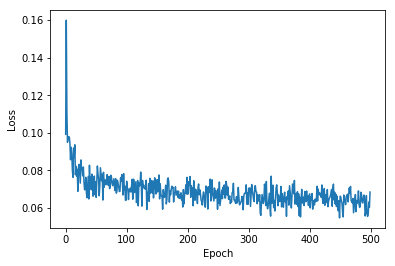

In [0]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')